# Effective Stiffness of Fiber Composite



## Introduction

This example demonstrates the use of the homogenization model from pyMKS on a set of fiber-like structures.  These structures are simulated to emulate fiber-reinforced polymer samples.  For a summary of homogenization theory and its use with effective stiffness properties please see the [Effective Siffness example](http://materialsinnovation.github.io/pymks/rst/stress_homogenization_2D.html).  This example will first generate a series of random microstructures with various fiber lengths and volume fraction.  The ability to vary the volume fraction is a new functionality of this example.  Then the generated stuctures will be used to calibrate and test the model based on simulated effective stress values.  Finally we will show that the simulated response compare favorably with those generated by the model.  

## Generating Structures

These first lines inport important packages that will be used to run pymks.  

In [28]:
# NBVAL_IGNORE_OUTPUT

from __future__ import print_function
import pymks

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from dask.multiprocessing import get
import dask.array as da
from pymks.fmks.correlations import auto_correlation
from sklearn.decomposition import PCA


Now we are defining the parameters which we will use to create the microstructures.  `n_samples` will determine how many microstructures of a particular volume fraction we want to create.  `size` determines the number of pixels we want to be included in the microstructure.  We will define the material properties to be used in the finite element in `elastic_modulus`, `poissons_ratio` and `macro_strain`.  `n_phases` and `grain_size` will determine the physical characteristics of the microstructure.  We are using a high aspect ratio in creating our microstructures to simulate fiber-like structures.  The `volume_fraction` variable will be used to vary the fraction of each phase.  The sum of the volume fractions must be equal to 1.  The `percent_variance` variable introduces some variation in the volume fraction up to the specified percentage.

In [4]:
from pymks.datasets.elastic_FE_simulation import ElasticFESimulation

In [5]:
sample_size = 100
n_samples = 4 * [sample_size]
size = (101, 101)
elastic_modulus = (1.3, 75)
poissons_ratio = (0.42, .22)
macro_strain = 0.001
n_phases = 2
grain_size = [(40, 2), (10, 2), (2, 40), (2, 10)]
v_frac = [(0.7, 0.3), (0.6, 0.4), (0.3, 0.7), (0.4, 0.6)]
per_ch = 0.1


Now we will create the microstructures and generate their responses using the `make_elastic_stress_random` function from pyMKS.  Four datasets are created to create the four different volume fractions that we are simulating.  Then the datasets are combined into one variable.   The volume fractions are listed in the variable `v_frac`.  Variation around the specified volume fraction can be obtained by varying `per_ch`.  The variation is randomly generated according a uniform distribution around the specified volume fraction.

In [6]:
from pymks.datasets import make_elastic_stress_random


dataset, stresses = make_elastic_stress_random(n_samples=n_samples, size=size, grain_size=grain_size,
                                                 elastic_modulus=elastic_modulus, poissons_ratio=poissons_ratio,
                                                 macro_strain=macro_strain, volume_fraction=v_frac,
                                                 percent_variance=per_ch)


Now we are going to print out a few microstructres to look at how the fiber length, orientation and volume fraction are varied.  

/nix/store/i47wyb7xqjnki251ibwzsxmd8kl5gp23-python3.6-scikit-learn-0.19.1/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


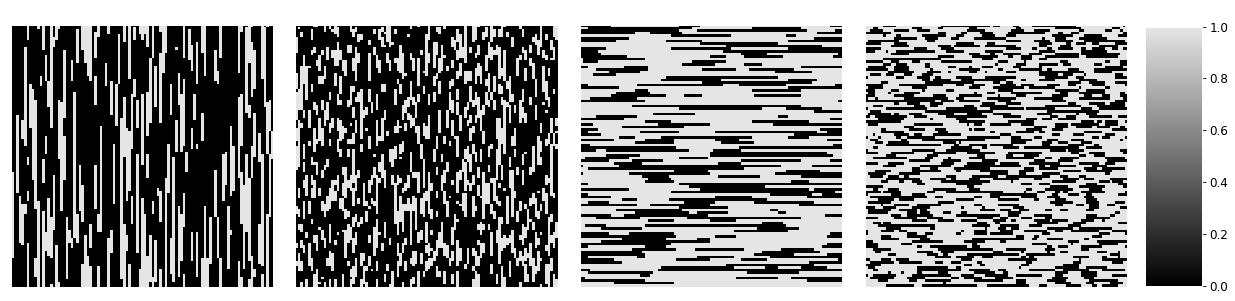

In [7]:
# NBVAL_IGNORE_OUTPUT

from pymks.tools import draw_microstructures
examples = dataset[::sample_size]
draw_microstructures(examples)


## Creating the Model

Next we are going to initiate the model. The MKSHomogenizationModel takes in microstructures and runs two-point statistics on them to get a statistical representation of the microstructures.  An expalnation of the use of two-point statistics can be found in the [Checkerboard Microstructure Example](http://materialsinnovation.github.io/pymks/rst/checker_board.html).  Then the model uses PCA and regression models to create a linkage between the calcualted properties and structures.  
Here we simply initiate the model.  

In [9]:
from sklearn.cross_validation import train_test_split
data_train, data_test, stress_train, stress_test = train_test_split(
    dataset, stresses, test_size=0.2, random_state=3)


In [10]:
# Claculate 2-point stats for the train

chunks=data_train.shape
Xa= da.from_array(data_train, chunks=chunks)
TrainStats=auto_correlation(Xa)


FlattenTrainStats=da.Array.flatten(TrainStats).reshape(TrainStats.shape[0],(TrainStats.shape[1]*TrainStats.shape[1]))
# pca = PCA(n_components=3) # I can also add this as a pipe
# pca.fit(FlattenTrainStats)
# TrainScores=pca.transform(FlattenTrainStats)

In [11]:
# Claculate 2-point stats for the test
chunks2=data_test.shape
Xb= da.from_array(data_test, chunks=chunks2)
TestStats=auto_correlation(Xb)

FlattenTestStats=da.Array.flatten(TestStats).reshape(TestStats.shape[0],(TestStats.shape[1]*TestStats.shape[1]))
# TestScores=pca.transform(FlattenTestStats)



In [14]:
from sklearn.grid_search import GridSearchCV

## Create the pipeline with the polynomail features than do the crossvalidation

bl=Pipeline([('reducer',PCA()),('poly', PolynomialFeatures()),('connector', LinearRegression())])





In [19]:
TrainStats.shape

(320, 101, 101)

In [20]:

params_to_tune = {'reducer__n_components': np.arange(1, 3),'poly__degree': np.arange(1, 3)}
#params_to_tune = {'poly__degree': np.arange(1, 4)}

# fit_params = {'size': dataset[0].shape}
gs = GridSearchCV(bl, param_grid=params_to_tune).fit(FlattenTrainStats, stress_train)



In [22]:
print(gs.best_estimator_)
print(gs.score(FlattenTrainStats,stress_train))


Pipeline(memory=None,
     steps=[('reducer', PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('connector', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
0.9985667697861441


In [23]:

bmodel=gs.best_estimator_

stress_predict = bmodel.predict(FlattenTestStats)

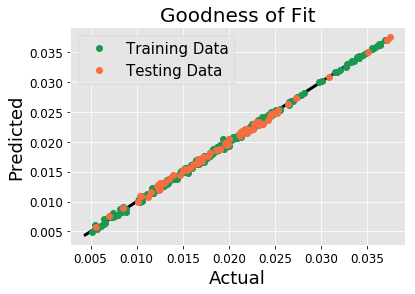

In [25]:
from pymks.tools import draw_goodness_of_fit


fit_data = np.array([stress_train, bmodel.predict(FlattenTrainStats)])
pred_data = np.array([stress_test, stress_predict])
draw_goodness_of_fit(fit_data, pred_data, ['Training Data', 'Testing Data'])


In [58]:
from sklearn.grid_search import GridSearchCV

## Create the pipeline with the polynomail features than do the crossvalidation

bl=Pipeline([('poly', PolynomialFeatures()),('connector', LinearRegression())])



bl.fit(data_train, stress_train)


bl.predict(data_test)


array([0.00878361, 0.02426754, 0.02331927, 0.0165876 , 0.01868185,
       0.02663192, 0.02117305, 0.02528594, 0.01613043, 0.02323616,
       0.02060753, 0.01756195, 0.02001819, 0.01504066, 0.02089932,
       0.02159144, 0.0232407 , 0.01315374, 0.01075099, 0.02297177,
       0.02173877, 0.01916127, 0.02480172, 0.02218771, 0.01476971,
       0.01511799, 0.02463801, 0.01614241, 0.01985316, 0.0217753 ,
       0.00976358, 0.02201426, 0.01159933, 0.0313649 , 0.01492302,
       0.02461004, 0.01582802, 0.01184506, 0.02377612, 0.02329202,
       0.01568924, 0.01775787, 0.03751664, 0.0169545 , 0.0076095 ,
       0.01735951, 0.01915847, 0.03632478, 0.0130332 , 0.01580947,
       0.02301558, 0.01243925, 0.01177076, 0.01435196, 0.01736086,
       0.01566884, 0.01384131, 0.0057473 , 0.0136857 , 0.01104371,
       0.0220722 , 0.02478159, 0.01718948, 0.01812523, 0.02285547,
       0.01696869, 0.0225465 , 0.01373316, 0.01611059, 0.0277328 ,
       0.0194327 , 0.01877282, 0.02267723, 0.02128971, 0.01120

In [61]:

params_to_tune = {'poly__degree': np.arange(1, 4)}
# fit_params = {'size': dataset[0].shape}
gs = GridSearchCV(bl, param_grid=params_to_tune).fit(data_train, stress_train)


In [66]:
print(gs.best_estimator_)
print(gs.score(data_train,stress_train))


Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('connector', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
0.9985662685245417


In [71]:

bmodel=gs.best_estimator_

stress_predict = bmodel.predict(data_test)


[0.00856907 0.02379144 0.02328875 0.01649115 0.01886161 0.02630761
 0.02132222 0.02513992 0.0165178  0.0231561  0.02052814 0.01684747
 0.01986515 0.01517549 0.02102752 0.02165946 0.02306465 0.01317677
 0.01069782 0.0229587  0.02185155 0.01935273 0.02486869 0.0222807
 0.01541169 0.01526681 0.02465085 0.01677999 0.01798989 0.0217855
 0.00978971 0.02213344 0.0114294  0.03077829 0.01433351 0.02527229
 0.01599876 0.01191203 0.02429746 0.02336796 0.01566164 0.01682662
 0.03747713 0.01690067 0.00732542 0.01736658 0.01939048 0.03709997
 0.01302164 0.01531391 0.02315611 0.01241952 0.01189909 0.01434179
 0.01726359 0.0154872  0.01295986 0.00540496 0.01372838 0.0108347
 0.0222359  0.02475776 0.01687933 0.01883027 0.02299639 0.01699236
 0.02134148 0.01268112 0.01628506 0.02733118 0.01961724 0.0186541
 0.02222751 0.02145917 0.01084781 0.03507004 0.01776984 0.01504677
 0.021988   0.02213154]


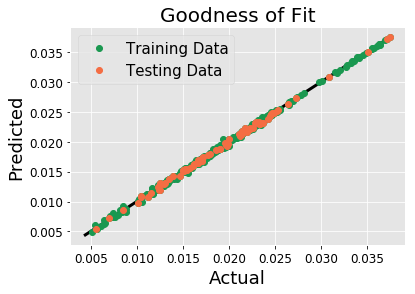

In [72]:
from pymks.tools import draw_goodness_of_fit


fit_data = np.array([stresses, bmodel.predict(Scores)])
pred_data = np.array([stress_test, stress_predict])
draw_goodness_of_fit(fit_data, pred_data, ['Training Data', 'Testing Data'])


In [7]:
from pymks import MKSHomogenizationModel
from pymks import PrimitiveBasis


p_basis = PrimitiveBasis(n_states=2, domain=[0, 1])
model = MKSHomogenizationModel(basis=p_basis, correlations=[(0, 0)], periodic_axes=[0, 1])













Now we are going to split our data into testing and training segments so we can test and see if our model can accurately predict the effective stress. 


In [8]:
from sklearn.cross_validation import train_test_split


flat_shape = (dataset.shape[0],) + (dataset[0].size,)
data_train, data_test, stress_train, stress_test = train_test_split(
    dataset.reshape(flat_shape), stresses, test_size=0.2, random_state=3)


We will use sklearn's GridSearchCV to optimize the `n_components` and `degree` for our model. Let's search over the range of 1st order to 3rd order polynomial for `degree` and 2 to 7 principal components for `n_components`.

In [67]:
from sklearn.grid_search import GridSearchCV


params_to_tune = {'degree': np.arange(1, 4), 'n_components': np.arange(2, 8)}
fit_params = {'size': dataset[0].shape}
gs = GridSearchCV(model, params_to_tune, fit_params=fit_params).fit(data_train, stress_train)


NameError: name 'model' is not defined

Let's take a look at the results.

In [10]:
print('Order of Polynomial', gs.best_estimator_.degree)
print('Number of Components', gs.best_estimator_.n_components)
print('R-squared Value', np.allclose(gs.score(data_test, stress_test), 0.863, rtol=1e-1))


Order of Polynomial 3
Number of Components 3
R-squared Value True


In [26]:
from pymks.tools import draw_gridscores_matrix

draw_gridscores_matrix(gs, ['n_components', 'degree'], score_label='R-Squared',
                       param_labels=['Number of Components', 'Order of Polynomial'])


KeyError: 'n_components'

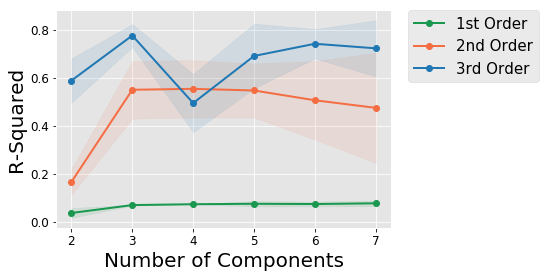

In [12]:
from pymks.tools import draw_gridscores

gs_deg_1 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 1]
gs_deg_2 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 2]
gs_deg_3 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 3]

draw_gridscores([gs_deg_1,  gs_deg_2, gs_deg_3], 'n_components', 
                data_labels=['1st Order', '2nd Order', '3rd Order'],
                param_label='Number of Components', score_label='R-Squared')


Our best model was found to have `degree` equal to 3 and `n_components` equal to 5. Let's go ahead and use it.

In [13]:
model = gs.best_estimator_

### Structures in PCA space

Now we want to draw how the samples are spread out in PCA space and look at how the testing and training data line up.  


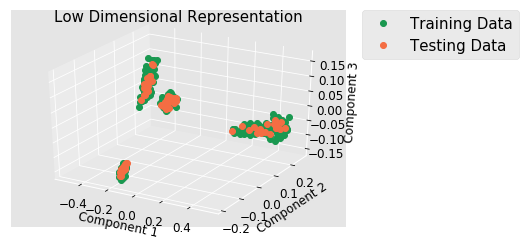

In [14]:
from pymks.tools import draw_components_scatter


stress_predict = model.predict(data_test)
draw_components_scatter([model.reduced_fit_data[:, :3],
                         model.reduced_predict_data[:, :3]],
                        ['Training Data', 'Testing Data'],
                        legend_outside=True)


It looks like there is pretty good agreement between the testing and the training data.  We can also see that the four different fiber sizes are seperated in the PC space.  

### Draw Goodness of fit

Now we are going to look at how well our model predicts the properties of the structures.  The calculated properties will be plotted against the properties generated by the model.  We should see a linear realtionship with a slope of 1.   

In [69]:
from pymks.tools import draw_goodness_of_fit


fit_data = np.array([stresses, model.predict(dataset)])
pred_data = np.array([stress_test, stress_predict])
draw_goodness_of_fit(fit_data, pred_data, ['Training Data', 'Testing Data'])


NameError: name 'model' is not defined

Yay! There is a good corrolation between the FE results and those predicted by our linkage.  